# Convolutional Neural Networks

A drawback of the ANN architectures that we have considered so far is that they do not consider the spatial information that might be hidden in a dataset. For example, how to interpret the value of a certain pixel usually depends on what can be seen nearby. For example, a blue pixel surrounded by white ones might be an eye, whereas a blue pixel surround by blue ones might be an ocean. In addition to color, neighboring pixels also encode structure. When looking at the MNIST data we might for example be looking for crosses (such as the center of an eight), T-shaped junctions (such as in the letter four) or half-circles (like in the letter three), whose number might then serve as features for our neural network.

One way to extract such features in image processing is by <i>convolving</i> an image with a <i>kernel</i>. This is illustrated for a 3x3 and a 7x7 kernel in the image below.

<center>
<img src="figs/convolution.svg" width="50%">
</center>

During a convolution, the kernel is swept across the input image, summing over a piece-wise multiplication of each element of the kernel with the underlying image pixels. As all multiplications are summed, such an operation yields only one pixel. As the kernel has to start somewhat inside the image (unless its borders are padded with appropriate values), we are loosing half the width of the kernel on each side. In the example above, a 3x3 kernel turns a 28x28 input image into a 26x26 output image and a 7x7 kernel turns it into a 22x22 pixel image. Mathematically, the convolution is defined as

$$x(n_1,n_2)*h(n_1,n_2)=\sum_{k_1=-\infty}^{\infty} \sum_{k_2=-\infty}^{\infty} h(k_1,k_2)x(n_1-k_1,n_2-k_2)$$

where bounds (here, infinity) need to be chosen so that the kernel starts at the upper left corner of the image and ends at the lower right corner. It is also possible to artificially grow the input image by adding pixels around it, which is known as <i>padding</i>. 


To see what kind of features even simple convolution kernels can extract, consider the following example:

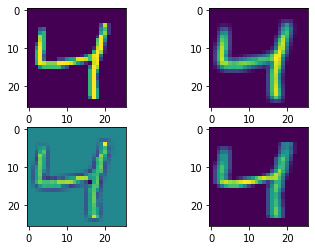

In [1]:
import matplotlib.pyplot as plt
from keras.datasets import mnist
from scipy import signal
import numpy as np

K=np.array([[[0,0,0],[0,1,0],[0,0,0]],
            [[1,1,1],[1,4,1],[1,1,1]],
            [[-1,-1,-1],[-1,8,-1],[-1,-1,-1]],
            [[0,0,0],[1,1,1],[0,0,0]]])

(X_train, y_train), (X_test, y_test) = mnist.load_data()

for I in range(2):
    for J in range(2):
        plt.subplot(2,2,I*2+J+1)
        plt.imshow(signal.convolve2d(X_train[2,:,:],K[I*2+J,:,:],mode='valid'))
plt.show()


Here, we have defined four different kernels (in the <code>K</code> array). The first one simply returns the value of the pixel itself, resulting in the original image, the second one implements a low-pass filter (also called a Gaussian Kernel), the third one emphasizes edges and the last one smooths the image only along one axis.

In this example, we used the <code>convolve2d</code> function from SciPy's signal processing toolbox. It is also possible to use keras' convolutional neural network implementation in which the kernel values are loaded as weights of the neural network, which is described in <a href="https://machinelearningmastery.com/pooling-layers-for-convolutional-neural-networks/">this article</a>.

## From convolutions to 2D neural networks

To look at how one individual pixel in the output above gets computed, we assume that the input pixel is labeled $x_{i,j}$ with $i$ the row and $j$ the column of this pixel. We also assume the entries of the convolution kernel to be indexed in a similar way. The first pixel of the output is then calculated by

$$ o_{0,0}=x_{0,0}w_{0,0}+x_{0,1}w_{0,1}+x_{0,2}w_{0,2}+x_{1,0}w_{1,0}+x_{1,1}w_{1,1}+x_{1,2}w_{1,2}+x_{2,0}w_{2,0}+x_{2,1}w_{2,1}+x_{2,2}w_{2,2} $$

This pixel is therefore simply computing the dot-product of the value of 9 pixels with the kernel weights. Adding a bias value and an activation function such as Relu is therefore identical to adding a hidden layer with 9 neurons. 

Performing the convolution by moving the convolution kernel with a width of (2r+1) across an entire XxY image is therefore akin to creating (X-2r)(Y-2r) "convolutional" neurons, and the resulting structure is called a <i>feature map</i>. Note, that the "weights" in the feature map - the entries of the kernel matrix - are identical for each neuron in the feature map. We can now repeat this step with additional kernels, resulting in multiple feature maps, which then form a <i>convolutional layer</i>.

As this structure is very similar to the conventional neural network structure, except for a large number of weights being identical, the parameters of each kernel can also be trained using back-propagation. A detailed derivation of how this can be implemented can be found in the article <a href="https://towardsdatascience.com/backpropagation-in-a-convolutional-layer-24c8d64d8509">Backpropagation in a convolutional layer</a>.

## Padding and striding

A convolution of kernel width $2r+1$ needs to reduce the input by $r$ on each side. If this is not desired, <i>padding</i> can be used to surround the input image with up to $r$ pixels, resulting in the output image having the same dimension than the input image. Instead of moving the convolution kernel pixel by pixel, skipping pixels will further reduce the size of the output image. The amount by which the convolution kernel is moved is known as <i>stride</i>. This is illustrated below for strides of one and three.

<center>
    <img src="figs/stride.svg" width="75%">
</center>



For a 2D input, the stride is usually provided as a tuple, expressing the stride along each axes. 

## Pooling

The feature maps that result from convolution each identify specific features that are defined by their kernels. Training finds these kernels by itself and some might fire on edges, others on intersections of lines, and yet again others on very specific patterns in the dataset. Activation functions further amplify this effect, making a clear distinction between whether a feature is present or not. In most practical applications, such features are rather sparse, however, and whether they exist in a larger area or not, might the most salient information. This can be achieved by a <i>pooling layer</i>.

A pooling operation applies a window to select the maximum (<i>MaxPooling</i>) or the average, among many other possible non-linear functions, from a window of a given size. The figure below shows the result of a MaxPooling layer with pool size of 3x3 and stride lengts of 1x1 and 3x3. Usually, the stride length is the same as the width of the window.

<center>
    <img src="figs/pooling.svg" width="75%">
</center>

Although the $max()$ function is not differentiable, MaxPooling can still be used in backpropagation by selectively passing the gradient to only that neuron which has shown the maximum activation and set the gradient of all other neurons in a pool to zero. In case an average pooling function has been used, the gradient is divided among all neurons in the pool to equal parts. 

## Flattening

The first step in previous neural network models has been to flatten a 2D input image into a one-dimensional vector. This has been the precondition to apply a dense layer and has been accomplished during preprocessing. Convolutional neural networks require multi-dimensional (2D images with multiple color channels) inputs, however. Turning a multi-dimensional tensor into a vector is known as <i>flattening</i> and results into simple reordering. For example, an RGB image of dimensioniality (28x28x3) might be turned into 20 convolutional filters, or 2352 individual neurons. A flattening layer arranges them again in a single vector.

# A sample CNN

The figure below shows a typical CNN that combines multiple convolutional and pooling layers. The network takes a 28x28 image as an input and trains 20 different 5x5 convolution kernels to create 20 feature maps of 28x28 each. This layer is followed by a maxpooling layer that downsamples each feature map by a factor two. These feature maps are then convolved with 50 5x5 convolution kernels to create 50 14x14 feature maps. These will again be downsampled by a maxpooling operation. The resulting 50 feature maps are then flattened and fed into a hidden layer of 500 neurons, and finally into a SoftMax-activated output layer with 10 neurons. 



<center>
    <img src="figs/cnn.svg" width="75%">
</center>

# Convolutional Networks beyond 2D image data

Convolution kernels emphasize areas of similarity. This can be readily understood when considering a simple kernel like [[0,9,0],[0,9,0],[0,9,0]] which emphasizes vertical lines, but ignores horizontal ones. Training a convolutional network therefore automatically finds regularities in the training set, as well as in the resulting feature map, often generating hierarchical representations by itself. A common example is a convolutional neural network for face detection in which early layers detect low-level, which then get recombined into noses, ears, mouth and eyes in deeper layers.

Convolutional neural networks are not limited to 2D image data, but can also be applied to 1D time series. Here, the will find distinct patterns, for example peaks in an electro-cardiogram, which can then be used in their plurality to classify complex signals. 